In [ ]:
!nvidia-smi

In [33]:
import torch
from easy_transformer.utils import (
    gelu_new,
    to_numpy,
    get_corner,
    lm_cross_entropy_loss,
)  # Helper functions
from easy_transformer.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer
from easy_transformer.experiments import (
    ExperimentMetric,
    AblationConfig,
    EasyAblation,
    EasyPatching,
    PatchingConfig,
)
import tqdm
import torch.nn.functional as F
import inflect
inflect_engine = inflect.engine()
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Moving model to device:  cuda
Moving model to device:  cuda
before training
Accuracy: 0.8 %
Loss 4.7394585609436035


  0%|          | 0/3001 [00:00<?, ?it/s]

Accuracy: 3.125 %
Loss 4.67634916305542


  4%|▍         | 117/3001 [00:00<00:21, 132.47it/s]

Accuracy: 32.8125 %
Loss 2.014650344848633


  7%|▋         | 222/3001 [00:01<00:19, 142.75it/s]

Accuracy: 81.25 %
Loss 0.6972610354423523


 11%|█         | 321/3001 [00:02<00:20, 129.61it/s]

Accuracy: 78.125 %
Loss 0.6786795854568481


 14%|█▍        | 417/3001 [00:03<00:26, 99.36it/s] 

Accuracy: 87.5 %
Loss 0.35323190689086914


 17%|█▋        | 518/3001 [00:04<00:24, 99.49it/s]

Accuracy: 96.875 %
Loss 0.08869458734989166


 21%|██        | 619/3001 [00:05<00:23, 102.44it/s]

Accuracy: 96.875 %
Loss 0.08110418170690536


 24%|██▎       | 712/3001 [00:06<00:23, 97.64it/s] 

Accuracy: 96.875 %
Loss 0.1629868894815445


 27%|██▋       | 812/3001 [00:07<00:22, 96.44it/s]

Accuracy: 93.75 %
Loss 0.09664350003004074


 30%|███       | 912/3001 [00:08<00:21, 95.81it/s]

Accuracy: 96.875 %
Loss 0.06739205867052078


 34%|███▍      | 1013/3001 [00:09<00:20, 97.73it/s]

Accuracy: 96.875 %
Loss 0.1177310198545456


 37%|███▋      | 1118/3001 [00:10<00:17, 109.36it/s]

Accuracy: 92.1875 %
Loss 0.16180700063705444


 40%|████      | 1214/3001 [00:11<00:15, 118.27it/s]

Accuracy: 95.3125 %
Loss 0.09672914445400238


 44%|████▍     | 1313/3001 [00:12<00:17, 97.29it/s] 

Accuracy: 95.3125 %
Loss 0.07750865072011948


 47%|████▋     | 1413/3001 [00:13<00:16, 95.11it/s]

Accuracy: 93.75 %
Loss 0.12897618114948273


 50%|█████     | 1514/3001 [00:14<00:15, 96.68it/s]

Accuracy: 96.875 %
Loss 0.07407044619321823


 54%|█████▍    | 1614/3001 [00:15<00:14, 95.63it/s]

Accuracy: 90.625 %
Loss 0.1326834261417389


 57%|█████▋    | 1714/3001 [00:16<00:13, 96.43it/s]

Accuracy: 96.875 %
Loss 0.04673801735043526


 61%|██████    | 1820/3001 [00:17<00:11, 99.76it/s] 

Accuracy: 95.3125 %
Loss 0.09937833249568939


 64%|██████▎   | 1912/3001 [00:18<00:11, 97.32it/s]

Accuracy: 96.875 %
Loss 0.0703931376338005


 67%|██████▋   | 2012/3001 [00:19<00:10, 94.95it/s]

Accuracy: 98.4375 %
Loss 0.05490987002849579


 70%|███████   | 2112/3001 [00:20<00:09, 96.27it/s]

Accuracy: 100.0 %
Loss 0.005159168969839811


 74%|███████▍  | 2224/3001 [00:21<00:06, 119.52it/s]

Accuracy: 100.0 %
Loss 0.0015752504114061594


 77%|███████▋  | 2321/3001 [00:22<00:05, 135.57it/s]

Accuracy: 98.4375 %
Loss 0.03827865421772003


 80%|████████  | 2407/3001 [00:22<00:04, 127.36it/s]

Accuracy: 98.4375 %
Loss 0.03246656432747841


 84%|████████▍ | 2518/3001 [00:24<00:04, 96.82it/s] 

Accuracy: 98.4375 %
Loss 0.020388809964060783


 87%|████████▋ | 2620/3001 [00:25<00:03, 97.48it/s]

Accuracy: 98.4375 %
Loss 0.09976913034915924


 91%|█████████ | 2725/3001 [00:26<00:02, 121.27it/s]

Accuracy: 98.4375 %
Loss 0.039693307131528854


 94%|█████████▍| 2825/3001 [00:26<00:01, 142.40it/s]

Accuracy: 100.0 %
Loss 0.001892573432996869


 97%|█████████▋| 2925/3001 [00:27<00:00, 159.78it/s]

Accuracy: 100.0 %
Loss 0.00042971092625521123


100%|██████████| 3001/3001 [00:27<00:00, 107.53it/s]


Accuracy: 98.4375 %
Loss 0.02394726872444153


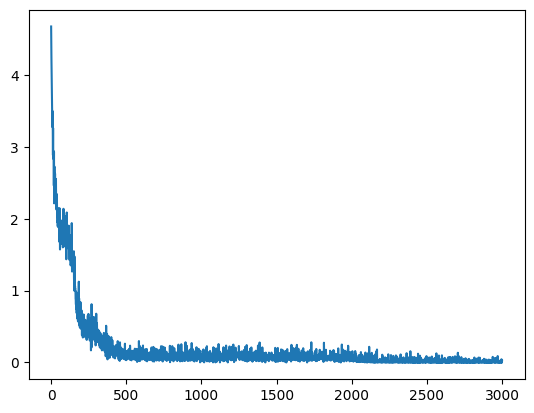

In [39]:
vocab_size = 100
sequence_length = 50
batch_size = 64

tiny_cfg = EasyTransformerConfig(
    d_model=32,
    d_head=16,
    n_heads=2,
    d_mlp=128,
    n_layers=1,
    n_ctx=50,
    act_fn="solu_ln",
    d_vocab=vocab_size,
    normalization_type="LN",
    seed=23,
)
tiny_model = EasyTransformer(tiny_cfg).to(device)
tiny_optimizer = torch.optim.Adam(tiny_model.parameters(), lr=1e-3)
cross_entropy_loss = torch.nn.CrossEntropyLoss()


def evaluate_model(test_model, batch_size, print_output, number_to_print=0):
    test_batch = torch.randint(0, vocab_size, (batch_size, sequence_length)).to(device)
    output_logits = test_model(test_batch, return_type="logits")

    smallest_elements = torch.min(test_batch, dim=1, keepdim=False)[0]
    one_hots = torch.nn.functional.one_hot(smallest_elements, num_classes=tiny_cfg.d_vocab).to(torch.float32)
    loss = cross_entropy_loss(output_logits[:, -1], one_hots)

    if print_output:
        output_probs = torch.softmax(output_logits, dim=-1) # Convert logits to probabilities
        output_tokens = torch.argmax(output_probs, dim=-1) # Get the most likely tokens
        output_tokens = output_tokens[:, -1] # Only take the last token of each sequence
        test_batch_lists = test_batch.cpu().tolist()
        outputs_list = output_tokens.cpu().tolist()
        correct_count = 0
        for index, (sequence, answer_given) in enumerate(list(zip(test_batch_lists, outputs_list))):
            correct_answer = min(sequence)
            answer_in_list = answer_given in sequence
            if answer_given == correct_answer:
                correct_count += 1
            if index < number_to_print:
                print("sequence: ", sequence, "answer_given: ", answer_given)
                if answer_given == correct_answer:
                    print("Correct! Answer is: ", correct_answer)
                elif answer_in_list:
                    answer_given_rank = sorted(list(set(sequence)), reverse=False).index(answer_given)
                    print("Incorrect! Answer given:", answer_given, "which is the", inflect_engine.ordinal(answer_given_rank + 1) , "smallest in the list (not including duplicate)")
                else:
                    print("Incorrect! Answer given:", answer_given, "which is not in the sequence")

        print("Accuracy:", correct_count / len(output_tokens) * 100, "%")
        print("Loss", loss.item())
        # print('output_logits[:, -1][0]', output_logits[:, -1][0])
        # print('one hots[0]', one_hots[0])

    return loss

loss_history = []
print('before training')
loss = evaluate_model(tiny_model, batch_size=1000, print_output=epoch % 100 == 0)
for epoch in tqdm.tqdm(range(3001)):
    loss = evaluate_model(tiny_model, batch_size=batch_size, print_output=epoch % 100 == 0, number_to_print=0)
    loss.backward()
    loss_history.append(loss.item())
    tiny_optimizer.step()
    tiny_optimizer.zero_grad()
plt.plot(loss_history)